In [5]:
from zigzag.classes.stages import *
from stream.classes.stages import *
from stream.visualization.schedule import (
    plot_timeline_brokenaxes,
)
from stream.visualization.memory_usage import plot_memory_usage
from stream.inputs.examples.hardware.cores.TPU_like import get_core as get_tpu_core
from stream.inputs.examples.hardware.cores.offchip import get_offchip_core
from stream.inputs.examples.hardware.nocs.mesh_2d import get_2d_mesh
from zigzag.classes.hardware.architecture.accelerator import Accelerator
from zigzag.classes.stages.Stage import Stage
from stream.classes.workload.computation_node import ComputationNode
from stream.classes.workload.simd_node import SimdNode
from stream.classes.workload.elementwise_node import ElementwiseNode
from stream.classes.workload.flatten_node import FlattenNode
from stream.classes.workload.dummy_node import DummyNode
import pickle

node_performances = None
class GetNodeHwPerformances(Stage):
    def __init__(self, list_of_callables, *args, node_hw_performances, **kwargs):
        super().__init__(list_of_callables, node_hw_performances=node_hw_performances, **kwargs)
        global node_performances
        node_performances = node_hw_performances
        
    def run(self):
        substage = self.list_of_callables[0](self.list_of_callables[1:], **self.kwargs)
        for cme, extra_info in substage.run():
            yield cme, extra_info


In [46]:
from sdf_expander import Sdf
import sys
from networkx.algorithms.minors import contracted_edge
from networkx.algorithms.components import node_connected_component
from networkx import DiGraph, Graph, induced_subgraph

class ConvertToSDF(Stage):
    def __init__(self, list_of_callables, *args, sdfContainer, workload, layer_cuts, start_layer, **kwargs):
        self.sdfContainer = sdfContainer
        self.workload = workload
        self.layer_cuts = layer_cuts
        self.start_layer = start_layer
        super().__init__(list_of_callables, workload=workload, **kwargs)
        
    def is_leaf(self):
        return True
        
    def run(self):
        import sympy as sp
        
        ox = sp.Symbol("ox")
        fx = sp.Symbol("fx")
        oy = sp.Symbol("oy")
        fy = sp.Symbol("fy")

        workload = self.workload.copy()
        edges = list(workload.edges())
        
        start_nodes = list(n for n in workload.nodes() if isinstance(n, ComputationNode) and n.name == self.start_layer)
        
        assert len(start_nodes) > 0
        
        [start_node, *_] = start_nodes
        
        for src, trg in edges:
            if hasattr(src, 'name') and hasattr(trg, 'name') and (src.name, trg.name) in self.layer_cuts:
                print(f"Removing {src} {trg}")
                workload.remove_edge(src, trg)
                
        workload_nodes = node_connected_component(Graph(workload), start_node)
        workload = induced_subgraph(workload, workload_nodes)
        workload = DiGraph(workload)
        
        for src, trg in edges:
            if isinstance(trg, DummyNode):
                contracted_edge(workload, (src, trg), False, False) 
                
        print([ n.name for n in workload.nodes() if isinstance(n, ComputationNode)])
        
        mrsdf = Sdf()
        for n in workload.nodes():
            mrsdf.add_actor(n.name)
        
        for n in workload.nodes():
            if isinstance(n, DummyNode):
                sys.exit("There should not be any DummyNode")
                
            if isinstance(n, FlattenNode):
                sys.exit(f"Unsupported Node {type(n)}")
                
            if not isinstance(n, ComputationNode):
                continue
            
            if isinstance(n, SimdNode) or isinstance(n, ElementwiseNode):
                x_stride = 1
                x_dilation = 1
                y_stride = 1
                y_dilation = 1
                x_padding = 0
                y_padding = 0
                x_convolution = 1
                y_convolution = 1
            else:
                relations = n.layer_attrs['dimension_relations']

                if len(relations) != 2:
                    sys.exit("Matrix Multiplication Unsupported")

                x_wise, y_wise = relations
                x_poly = sp.Poly(x_wise.split("=")[1])
                y_poly = sp.Poly(y_wise.split("=")[1])

                x_stride = x_poly.coeff_monomial(ox)
                x_dilation = x_poly.coeff_monomial(fx)
                y_stride = y_poly.coeff_monomial(oy)
                y_dilation = y_poly.coeff_monomial(fy)
                x_padding, _ = n.padding['IX']
                y_padding, _ = n.padding['IY']
                x_convolution = n.loop_ranges['FX'][1] - n.loop_ranges['FX'][0]
                y_convolution = n.loop_ranges['FY'][1] - n.loop_ranges['FY'][0]
                
            initial_tokens = 1 + x_padding - x_convolution
            for src, _ in workload.in_edges(n):
                mrsdf.add_channel(src.name, 1, n.name, x_stride, initial_tokens)
                
        yield None, mrsdf 
    

In [47]:
sdfContainer = []

mainstage = MainStage(
    [  # Initializes the MainStage as entry point
        AcceleratorParserStage,  # Parses the accelerator
        StreamONNXModelParserStage,  # Parses the ONNX Model into the workload
        ConvertToSDF,
    ],
    accelerator="architecture.eyeriss_like_dual_core",  # required by AcceleratorParserStage
    workload_path="./problems/resnet18.onnx",  # required by ModelParserStage
    mapping_path="mapping.resnet_mapping",
    sdfContainer=sdfContainer,
    layer_cuts=[("/layer4/layer4.1/relu_1/Relu", "/avgpool/GlobalAveragePool")],
    start_layer="/conv1/Conv",
)

[(_, mrsdf), *_] = mainstage.run()

Removing ReluNode() ComputationNode(46,)
['/conv1/Conv', '/maxpool/MaxPool', '/layer1/layer1.0/conv1/Conv', '/layer1/layer1.0/conv2/Conv', '/layer1/layer1.0/Add', '/layer1/layer1.1/conv1/Conv', '/layer1/layer1.1/conv2/Conv', '/layer1/layer1.1/Add', '/layer2/layer2.0/conv1/Conv', '/layer2/layer2.0/conv2/Conv', '/layer2/layer2.0/downsample/downsample.0/Conv', '/layer2/layer2.0/Add', '/layer2/layer2.1/conv1/Conv', '/layer2/layer2.1/conv2/Conv', '/layer2/layer2.1/Add', '/layer3/layer3.0/conv1/Conv', '/layer3/layer3.0/conv2/Conv', '/layer3/layer3.0/downsample/downsample.0/Conv', '/layer3/layer3.0/Add', '/layer3/layer3.1/conv1/Conv', '/layer3/layer3.1/conv2/Conv', '/layer3/layer3.1/Add', '/layer4/layer4.0/conv1/Conv', '/layer4/layer4.0/conv2/Conv', '/layer4/layer4.0/downsample/downsample.0/Conv', '/layer4/layer4.0/Add', '/layer4/layer4.1/conv1/Conv', '/layer4/layer4.1/conv2/Conv', '/layer4/layer4.1/Add']


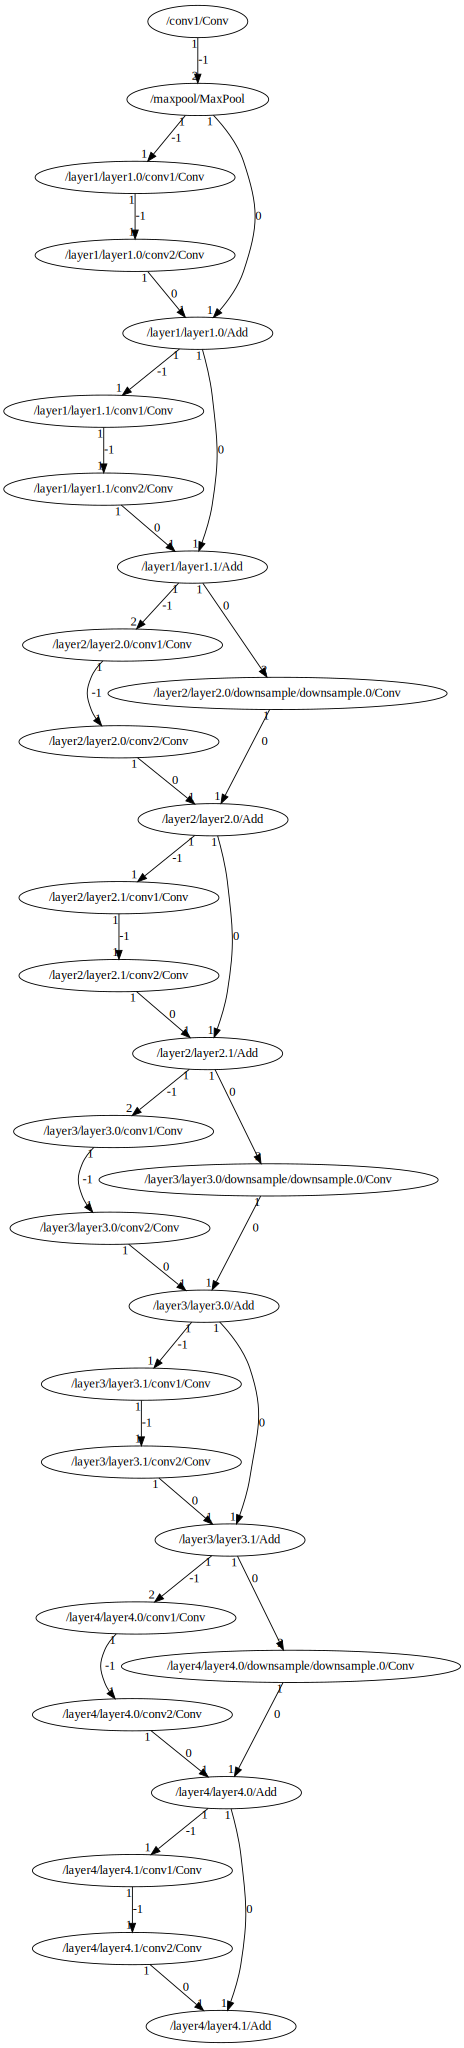

In [48]:
mrsdf

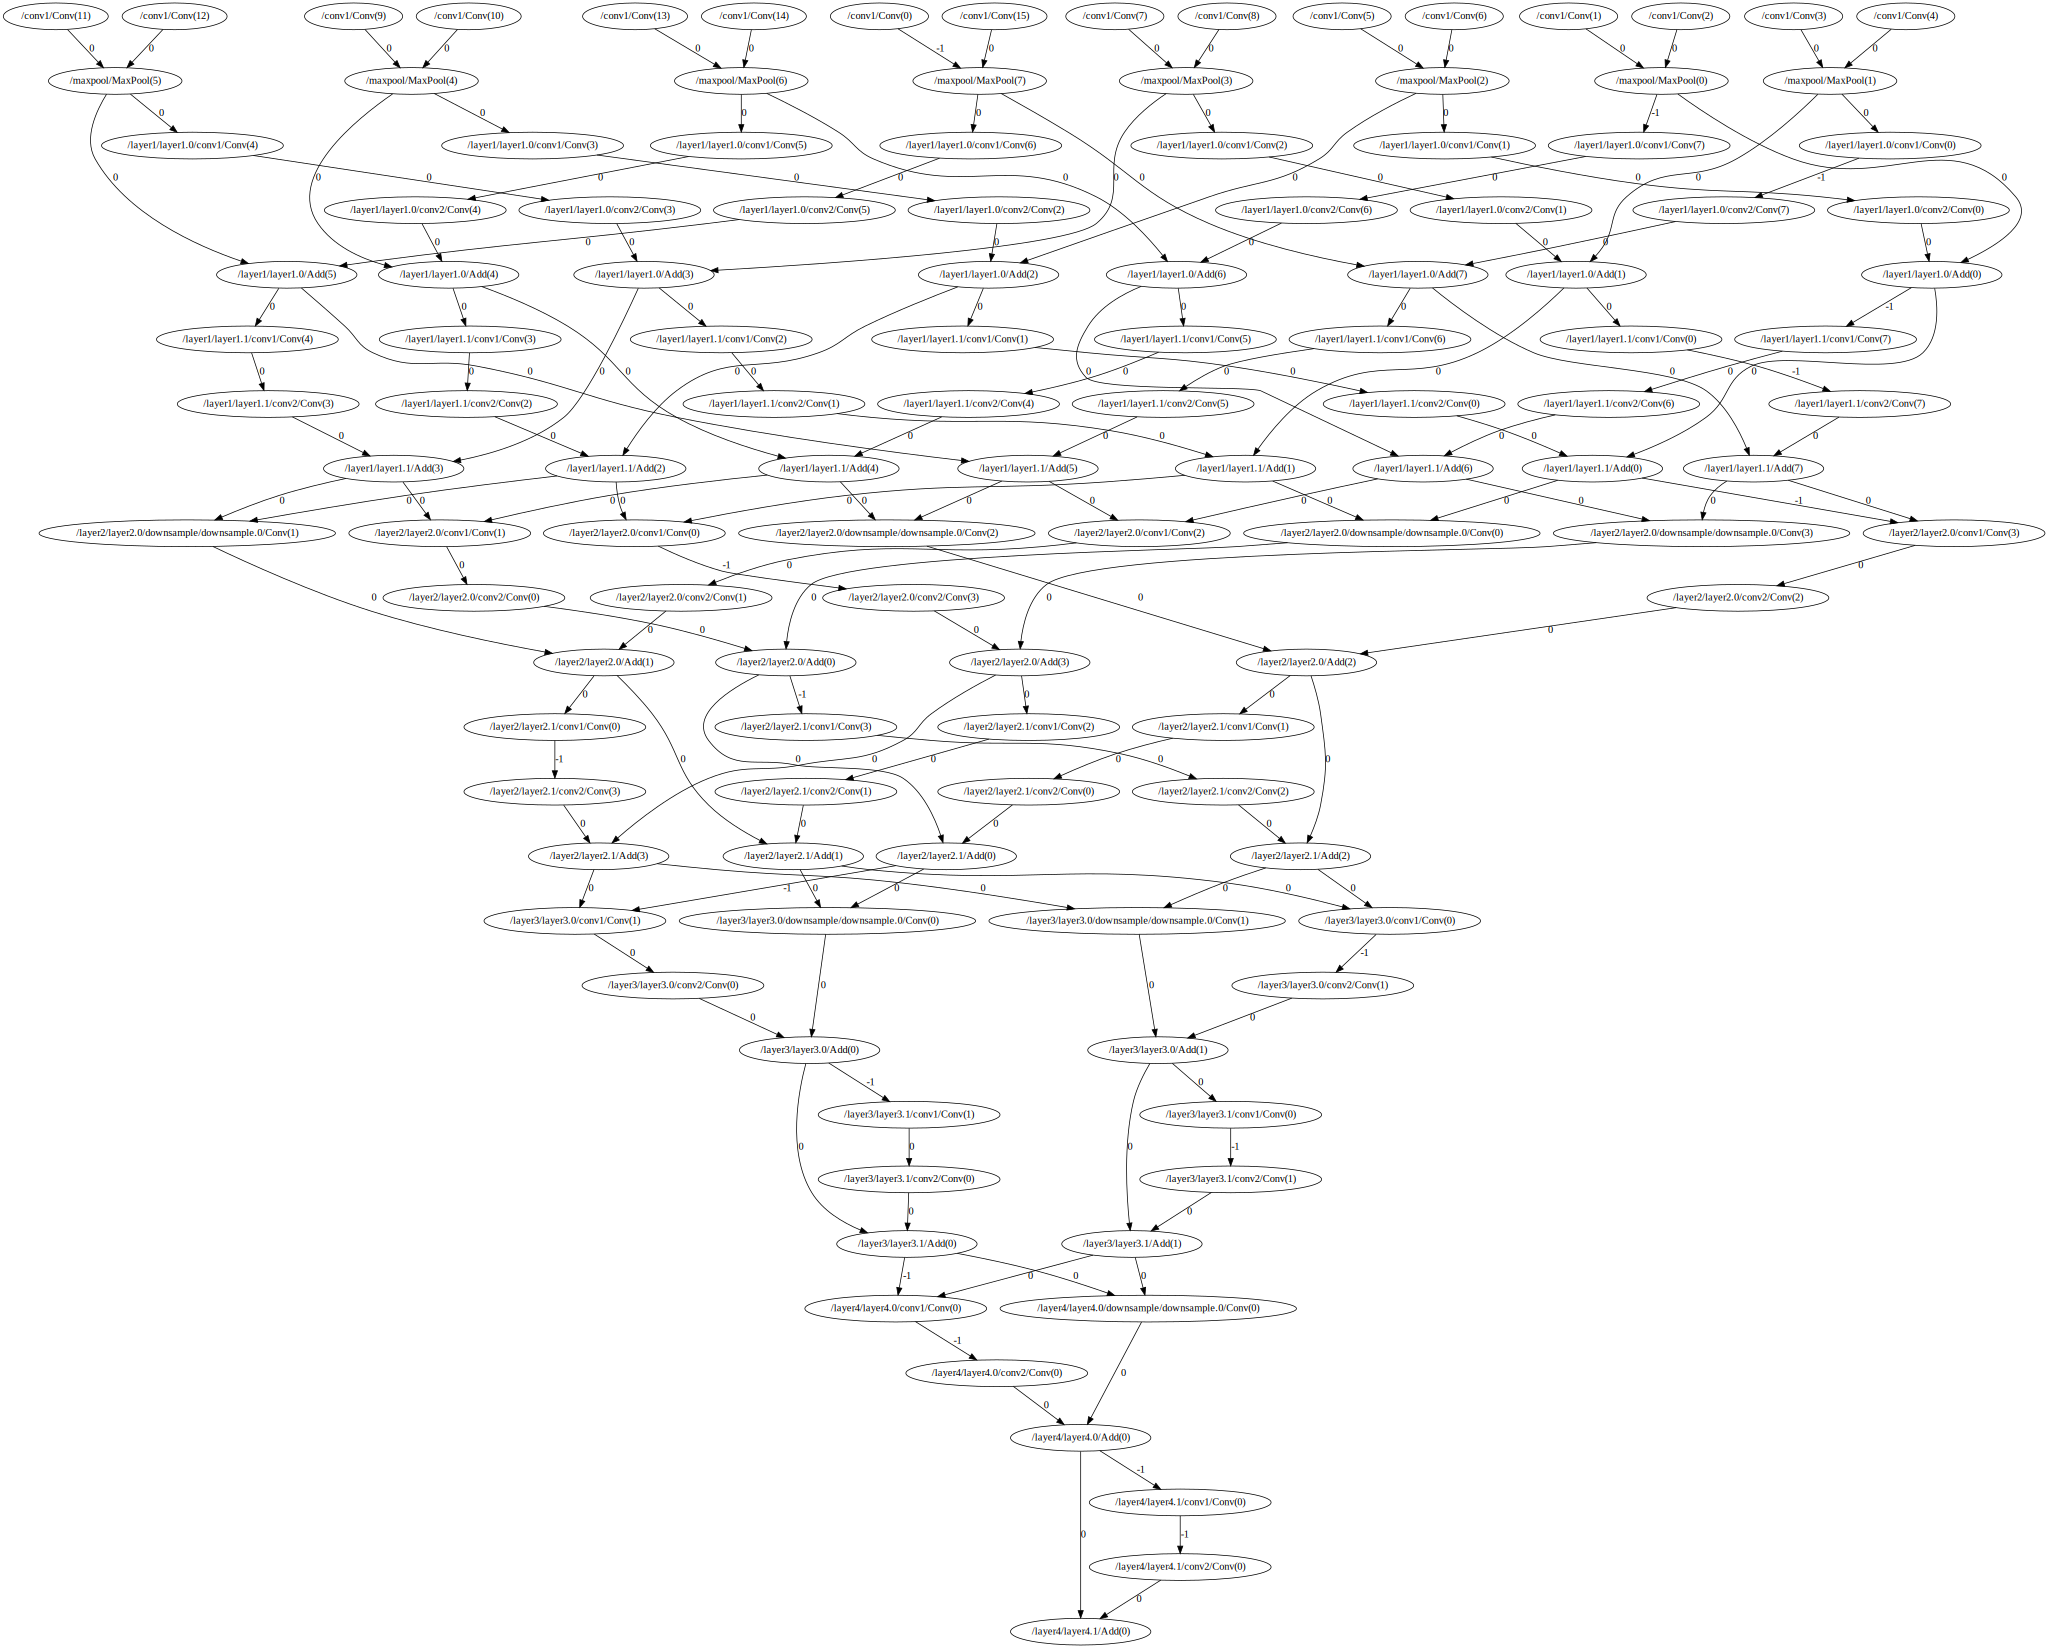

In [49]:
mrsdf.to_hsdf()

In [26]:
from networkx.algorithms.minors import contracted_edge

contracted_edge(workload, e, False, True).edges

OutEdgeView([(ComputationNode(0,), ComputationNode(2,)), (ComputationNode(2,), ComputationNode(3,)), (ComputationNode(2,), ComputationNode(6,)), (ComputationNode(3,), ReluNode()), (ReluNode(), ComputationNode(5,)), (ComputationNode(5,), ComputationNode(6,)), (ComputationNode(6,), ReluNode()), (ReluNode(), ComputationNode(8,)), (ReluNode(), ComputationNode(11,)), (ComputationNode(8,), ReluNode()), (ReluNode(), ComputationNode(10,)), (ComputationNode(10,), ComputationNode(11,)), (ComputationNode(11,), ReluNode()), (ReluNode(), ComputationNode(13,)), (ReluNode(), ComputationNode(16,)), (ComputationNode(13,), ReluNode()), (ReluNode(), ComputationNode(15,)), (ComputationNode(15,), ComputationNode(17,)), (ComputationNode(16,), ComputationNode(17,)), (ComputationNode(17,), ReluNode()), (ReluNode(), ComputationNode(19,)), (ReluNode(), ComputationNode(22,)), (ComputationNode(19,), ReluNode()), (ReluNode(), ComputationNode(21,)), (ComputationNode(21,), ComputationNode(22,)), (ComputationNode(22,

In [67]:
import sympy as sp
from sympy.abc import ox

f = sp.Poly("ox + fx")

ImportError: cannot import name 'ox' from 'sympy.abc' (/home/andful/.local/lib/python3.10/site-packages/sympy/abc.py)

In [66]:
f.coeffs()
f.as_list()

[[1], [1, 0]]

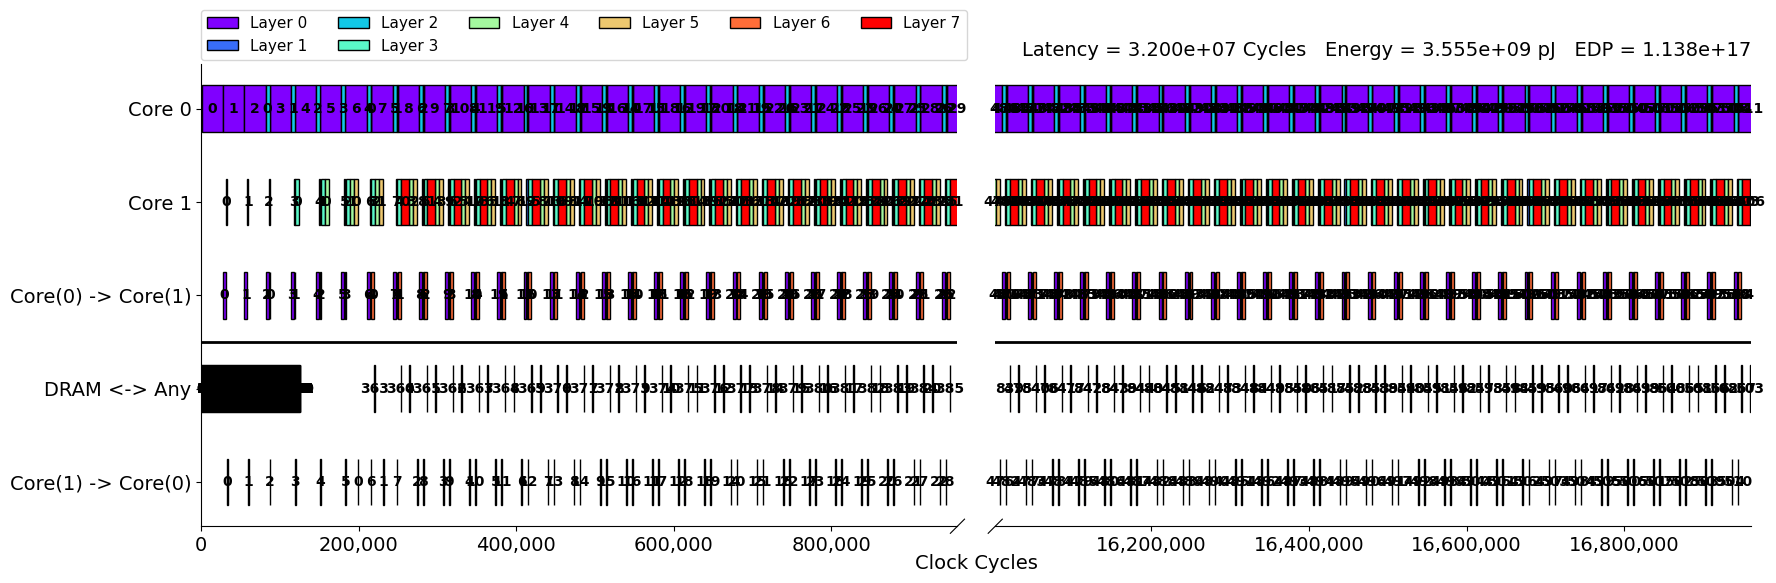

Saved memory usage fig to /tmp/memory


<Figure size 640x480 with 0 Axes>

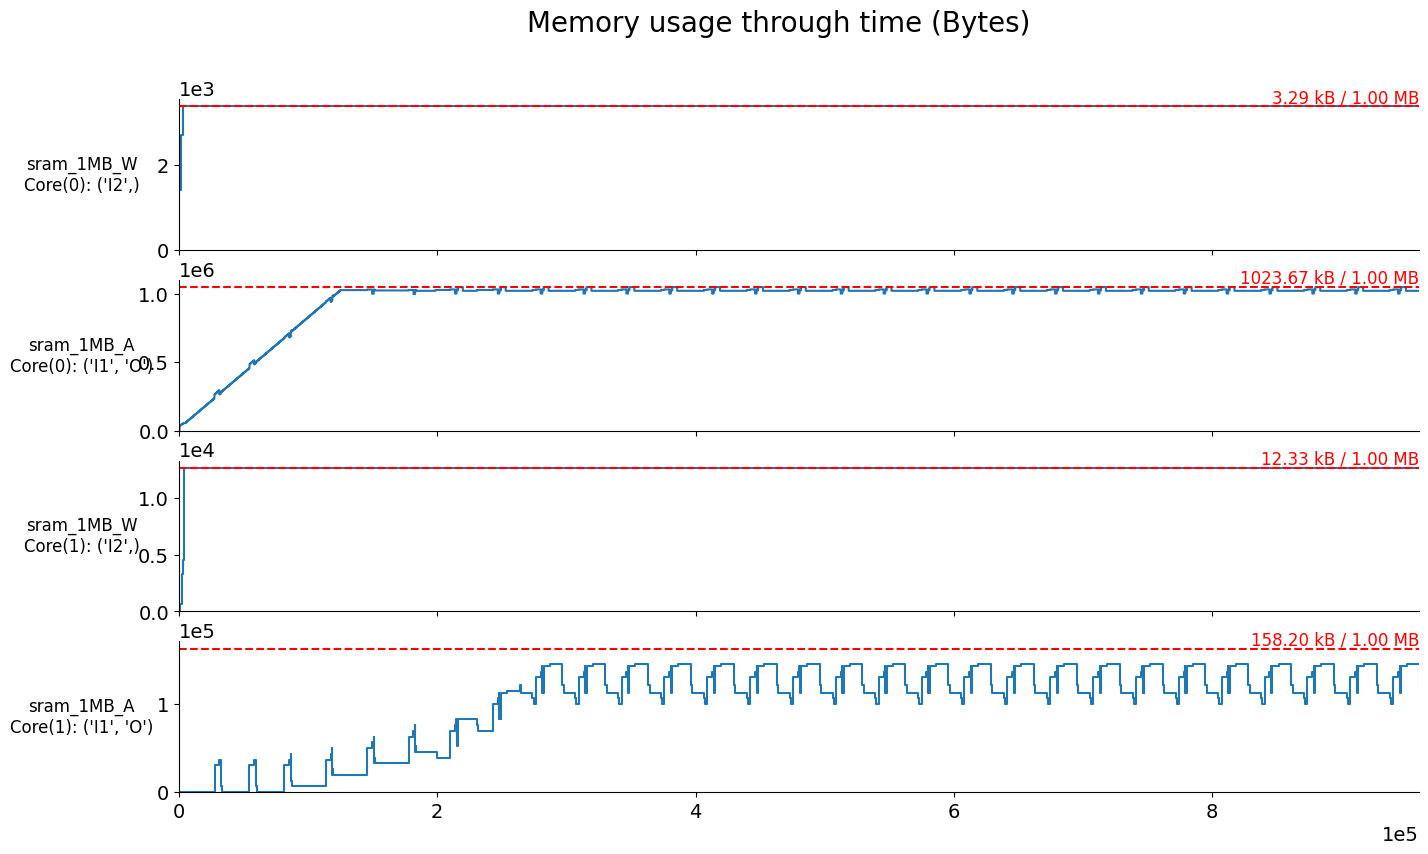

In [3]:
mainstage = MainStage(
    [  # Initializes the MainStage as entry point
        AcceleratorParserStage,  # Parses the accelerator
        StreamONNXModelParserStage,  # Parses the ONNX Model into the workload
        # UserDefinedModelParserStage,  # Parses the user-defined Model into the workload
        GenerateCNWorkloadHybridStage,
        IntraCoreMappingStage,
        GetNodeHwPerformances,
        InterCoreMappingStage,
    ],
    accelerator="architecture.tpu_like_dual_core",  # required by AcceleratorParserStage
    workload_path="./problems/fsrcnn.onnx",  # required by ModelParserStage
    mapping_path="mapping.super_resolution_mapping",  # required by ModelParserStage
    loma_lpf_limit=6,  # required by LomaStage
    nb_ga_individuals=2,  # number of individuals in each genetic algorithm generation
    nb_ga_generations=1,  # number of genetic algorithm generations
    node_hw_performances_path="./core-layer-mapping.pickle",  # saved node_hw_performances to skip re-computation
    plot_hof=False,  # Save schedule and memory usage plot of each individual in the Genetic Algorithm hall of fame
    plot_file_name="plot",
    plot_full_schedule=False,
    plot_data_transfer=False,
    cn_define_mode=1,
    hint_loops=[("OX", "all")],
    scheduler_candidate_selection="latency",
    operands_to_prefetch=[],
)

[scme, *_], _ = mainstage.run()

plot_timeline_brokenaxes(
    scme,
    False,
    section_start_percent=(0,50),
    percent_shown=(3,3),
    plot_data_transfer=True,
    fig_path="/tmp/timeline",
)

plot_memory_usage(scme, (0,), (3,), fig_path="/tmp/memory")

In [4]:
for k, item in node_performances.items():
    print(f"Layer {k.id[0]}")
    for op in k.operand_tensors.keys():
        tensor = k.operand_tensors[op]
        operand_precision = k.operand_precision[op]
        print(f"\t{op}: size={tensor.size} operand-size={operand_precision} loops= {','.join(map(lambda x: f'{x[0]}:[{x[1][0]}..{x[1][1]})', zip(tensor.loop_dimensions, tensor.loop_ranges)))}")
    print("\n\t\tLatency\tEnergy")
    for core, cme in item.items():
        print(f"\tCore {core.id}:\t{cme.latency_total1}\t{cme.energy_total}")
    print()

Layer 0
	O: size=241920 operand-size=16 loops= B:[0..1),G:[0..1),K:[0..56),OY:[0..540),OX:[0..1)
	W: size=11200 operand-size=8 loops= K:[0..56),C:[0..1),FY:[0..5),FX:[0..5)
	I: size=21760 operand-size=8 loops= B:[0..1),G:[0..1),C:[0..1),IY:[-2..542),IX:[-2..3)

		Latency	Energy
	Core 0:	27050	1049283.7349999999

Layer 1
	O: size=51840 operand-size=16 loops= B:[0..1),G:[0..1),K:[0..12),OY:[0..540),OX:[0..1)
	W: size=5376 operand-size=8 loops= K:[0..12),C:[0..56),FY:[0..1),FX:[0..1)
	I: size=241920 operand-size=8 loops= B:[0..1),G:[0..1),C:[0..56),IY:[0..540),IX:[0..1)

		Latency	Energy
	Core 1:	1317	132221.676

Layer 2
	O: size=51840 operand-size=16 loops= B:[0..1),G:[0..1),K:[0..12),OY:[0..540),OX:[0..1)
	W: size=10368 operand-size=8 loops= K:[0..12),C:[0..12),FY:[0..3),FX:[0..3)
	I: size=156096 operand-size=8 loops= B:[0..1),G:[0..1),C:[0..12),IY:[-1..541),IX:[-1..2)

		Latency	Energy
	Core 0:	5012	200994.318

Layer 3
	O: size=51840 operand-size=16 loops= B:[0..1),G:[0..1),K:[0..12),O

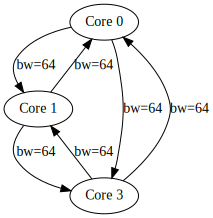

In [6]:
import graphviz
from architecture.tpu_like_dual_core import cores_graph

dot = graphviz.Digraph()
for core in cores_graph.nodes():
    dot.node(str(core.id), f"Core {core.id}" if core.id != 2 else "DRAM")

for (source, target, channel) in cores_graph.edges.data():
    dot.edge(str(source.id), str(target.id), label=f"bw={channel['cl'].bandwidth}")
    
dot

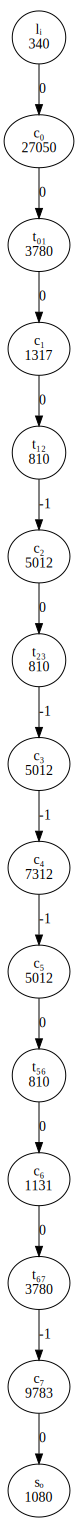

In [7]:
from cyclic_scheduling import CyclicSchedulingProblem
from math import ceil

problem = CyclicSchedulingProblem()

problem.add_processor('Core 0')
problem.add_processor('Core 1')
problem.add_processor('Core 0 -> Core 1')
problem.add_processor('DRAM <-> Any')
problem.add_processor('Core 1 -> Core 0')

problem.add_actor('lᵢ', ceil(21760/64), 'DRAM <-> Any', '#8000ff') # Loading of input 
problem.add_actor('c₀', 27050, 'Core 0', '#8000ff') # Layer 0
problem.add_actor('t₀₁', ceil(241920/64), 'Core 0 -> Core 1', '#8000ff') # Transfer from Core 0 to Core 1
problem.add_actor('c₁', 1317, 'Core 1', '#376bf5') # Layer 1
problem.add_actor('t₁₂', ceil(51840/64), 'Core 1 -> Core 0', '#376bf5')
problem.add_actor('c₂', 5012, 'Core 0', '#12c6e3') # Layer 2 
problem.add_actor('t₂₃', ceil(51840/64), 'Core 0 -> Core 1', '#12c6e3')
problem.add_actor('c₃', 5012, 'Core 1', '#5bf9c9') # Layer 3 
problem.add_actor('c₄', 7312, 'Core 1', '#a2f69d') # Layer 4 
problem.add_actor('c₅', 5012, 'Core 1', '#eac66e') # Layer 5
problem.add_actor('t₅₆', ceil(51840/64), 'Core 1 -> Core 0', '#eac66e')
problem.add_actor('c₆', 1131, 'Core 0', '#fc6c37') # Layer 6
problem.add_actor('t₆₇', ceil(241920/64), 'Core 0 -> Core 1', '#fc6c37')
problem.add_actor('c₇', 9783, 'Core 1', '#fd0000') # Layer 7 
problem.add_actor('sₒ', ceil(69120/64), 'DRAM <-> Any', '#fd0000') # Store of output


problem.add_channel('lᵢ', 'c₀')
problem.add_channel('c₀', 't₀₁')
problem.add_channel('t₀₁', 'c₁')
problem.add_channel('c₁', 't₁₂')
problem.add_channel('t₁₂', 'c₂', -1)
problem.add_channel('c₂', 't₂₃')
problem.add_channel('t₂₃', 'c₃', -1)
problem.add_channel('c₃', 'c₄', -1)
problem.add_channel('c₄', 'c₅', -1)
problem.add_channel('c₅', 't₅₆')
problem.add_channel('t₅₆', 'c₆')
problem.add_channel('c₆', 't₆₇')
problem.add_channel('t₆₇', 'c₇', -1)
problem.add_channel('c₇', 'sₒ')
problem

In [27]:
solution = problem.solve()
solution.plot_with_processors()

CyclicSchedulingPlot(data='{"problem": {"actors": [{"name": "l\\u1d62", "execution_time": 340, "processor": "D…

In [9]:
import numpy as np

sol = solution.solution(relaxed=True)
cycle_time = sol.cycle_time
start_time = np.array(sol.t)
end_time = start_time + np.fromiter(map(lambda a: a.execution_time, problem.actors), int)

In [10]:
cycle_time

33193

In [11]:
start_time

array([     0.,    340.,  42251.,  59586.,  60904.,  94907., 107827.,
       141830., 180035., 220539., 225738., 226548., 227679., 264652.,
       297657.])

In [12]:
end_time

array([   340.,  27390.,  46031.,  60903.,  61714.,  99919., 108637.,
       146842., 187347., 225551., 226548., 227679., 231459., 274435.,
       298737.])

In [13]:
memory_cost = np.array([
    # start core 0, end core 0, start core 1, end core 1
    [ 21760,      0,      0,      0], # Load Layer 0 I Tensor (DRAM <-> Any)
    [241920, -21760,      0,      0], # Layer 0 (Core 0)
    [     0,-241920, 241920,      0], # Transfer Layer 0 -> Layer 1 (Core 0 -> Core 1)
    [     0,      0,  51840,-241920], # Layer 1 (Core 1)
    [ 51840,      0,      0, -51840], # Transfer Layer 1 -> Layer 2 (Core 1 -> Core 0)
    [ 51840,  -51840,     0,      0], # Layer 2 (Core 0)
    [     0,  -51840, 51840,      0], # Transfer Layer 2 -> Layer 3 (Core 0 -> Core 1)
    [     0,       0, 51840, -51840], # Layer 3 (Core 1)
    [     0,       0, 51840, -51840], # Layer 4 (Core 1)
    [     0,       0, 51840, -51840], # Layer 5 (Core 1)
    [ 51840,       0,     0, -51840], # Transfer Layer 5 -> Layer 6 (Core 1 -> Core 0)
    [241920,  -51840,     0,      0], # Layer 6 (Core 0)
    [     0, -241920,241920,      0], # Transfer Layer 6 -> Layer 7 (Core 0 -> Core 1)
    [     0,       0, 69120,-241920], # Layer 7 (Core 1)
    [     0,       0,     0, -69120]  # Store Layer 7 O Tensor (DRAM <-> Any)
])

In [14]:
core0_start, core0_end, core1_start, core1_end = memory_cost.T

In [21]:
from math import ceil
sample = lambda sample_time, first_fire_time, cost: np.sum(cost*np.maximum(np.ceil((sample_time - first_fire_time)/cycle_time), 0))

In [22]:
sample_core0 = np.vectorize(lambda t: sample(t, start_time, core0_start) + sample(t, end_time, core0_end))
sample_core1 = np.vectorize(lambda t: sample(t, start_time, core1_start) + sample(t, end_time, core1_end))

In [23]:
def get_change_points(events, cycle_time, end_time):
    from math import ceil
    from heapq import heapify, heappop, heappush
    events = list(events)
    heapify(events)
    while True:
        t = heappop(events)
        if t > end_time:
            break
        yield t
        heappush(events, t + cycle_time)

In [24]:
sample_times =  np.fromiter(get_change_points(list(start_time) + list(end_time), cycle_time, 400000), int)

Text(0, 78.046875, '78.046875 kB')

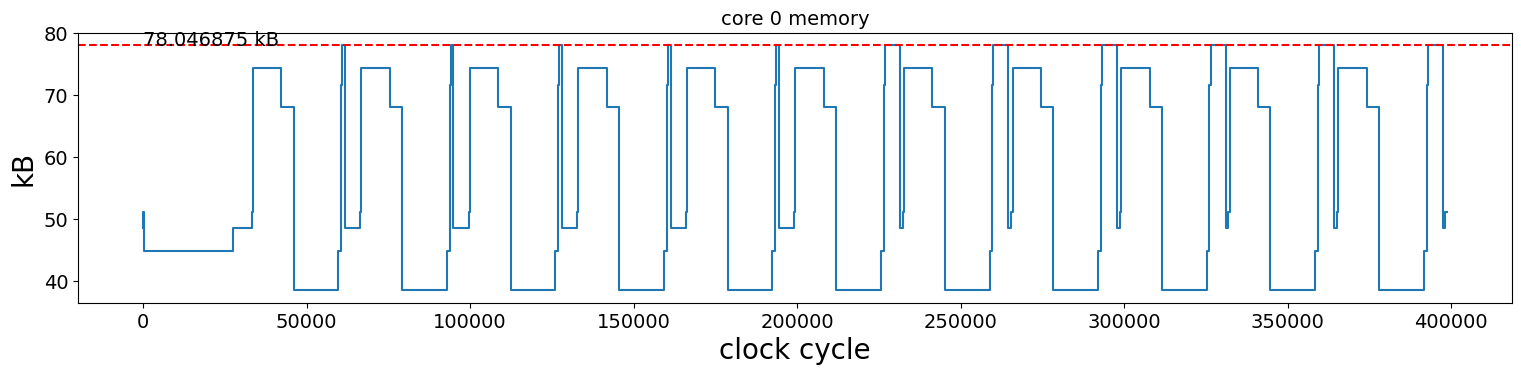

In [25]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(18.5, 3.5)
plt.title("core 0 memory")
plt.xlabel("clock cycle")
plt.ylabel("kB")
y = sample_core0(sample_times)/(8*1024)
plt.step(sample_times, y)
max_y = np.max(y)
plt.axhline(y=max_y, color='r', linestyle='--')
plt.text(0, max_y, f"{max_y} kB")

Text(0, 105.46875, '105.46875 kB')

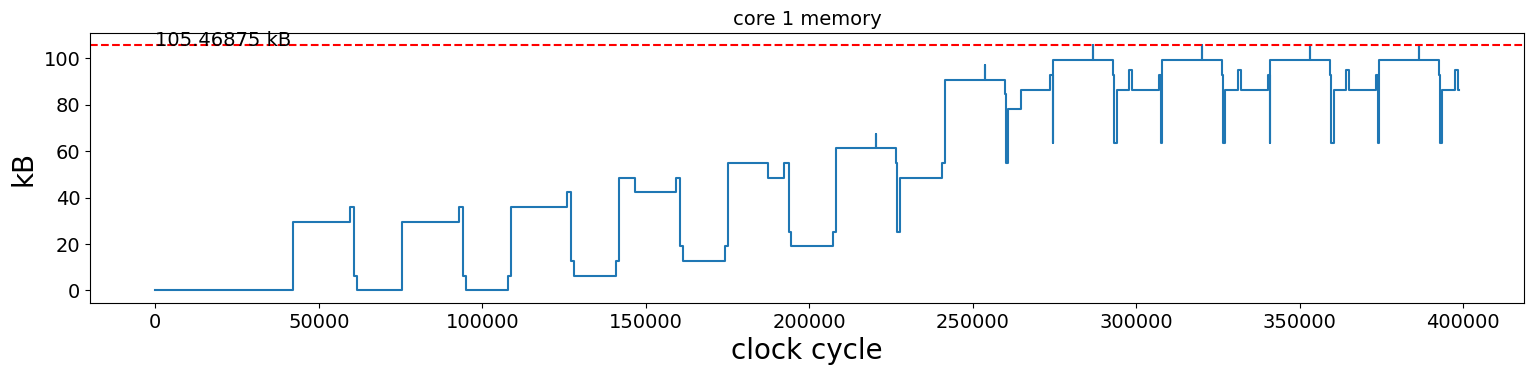

In [20]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(18.5, 3.5)
plt.title("core 1 memory")
plt.xlabel("clock cycle")
plt.ylabel("kB")
y = sample_core1(sample_times)/(8*1024)
plt.step(sample_times, y)
max_y = np.max(y)
plt.axhline(y=max_y, color='r', linestyle='--')
plt.text(0, max_y, f"{max_y} kB")